In [10]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor as SklearnDecisionTreeRegressor
# Generate 1D example data
np.random.seed(122)
def f_truth(X, noise_var=0.0**2):
    n_samples = X.shape[0]
    return np.sin(8 * np.pi * X).ravel() + noise_var * np.random.randn(n_samples)
 
from scipy.optimize import minimize_scalar 

def lp_minimizer(x, p):
    """
    Find the Lp minimizer for the given 1D vector x and a specified value of p.
    Returns (minimizer, minimal_value).
    """
    def objective(m):
        return np.sum(np.abs(x - m) ** p)
    result = minimize_scalar(objective, method='bounded', bounds=(np.min(x), np.max(x)))
    return result.x, result.fun

def custom_tree_predict(X_grid, s1, s2, s3, s4, s5, s6, s7):
    predictions = np.zeros(X_grid.shape[0])

    # Form the partitions based on the split points
    left_mask = X_grid.ravel() < s1
    right_mask = ~left_mask

    left_left_mask = (X_grid.ravel() < s2) & left_mask
    left_right_mask = ~left_left_mask & left_mask

    left_left_left_mask = (X_grid.ravel() < s4) & left_left_mask
    left_left_right_mask = ~left_left_left_mask & left_left_mask

    left_right_left_mask = (X_grid.ravel() < s5) & left_right_mask
    left_right_right_mask = ~left_right_left_mask & left_right_mask

    right_left_mask = (X_grid.ravel() < s3) & right_mask
    right_right_mask = ~right_left_mask & right_mask

    right_left_left_mask = (X_grid.ravel() < s6) & right_left_mask
    right_left_right_mask = ~right_left_left_mask & right_left_mask

    right_right_left_mask = (X_grid.ravel() < s7) & right_right_mask
    right_right_right_mask = ~right_right_left_mask & right_right_mask

    # Assign predictions to each partition
    predictions[left_left_left_mask] = np.mean(y[(X.ravel() < s1) & (X.ravel() < s2) & (X.ravel() < s4)])
    predictions[left_left_right_mask] = np.mean(y[(X.ravel() < s1) & (X.ravel() < s2) & (X.ravel() >= s4)])

    predictions[left_right_left_mask] = np.mean(y[(X.ravel() < s1) & (X.ravel() >= s2) & (X.ravel() < s5)])
    predictions[left_right_right_mask] = np.mean(y[(X.ravel() < s1) & (X.ravel() >= s2) & (X.ravel() >= s5)])

    predictions[right_left_left_mask] = np.mean(y[(X.ravel() >= s1) & (X.ravel() < s3) & (X.ravel() < s6)])
    predictions[right_left_right_mask] = np.mean(y[(X.ravel() >= s1) & (X.ravel() < s3) & (X.ravel() >= s6)])

    predictions[right_right_left_mask] = np.mean(y[(X.ravel() >= s1) & (X.ravel() >= s3) & (X.ravel() < s7)])
    predictions[right_right_right_mask] = np.mean(y[(X.ravel() >= s1) & (X.ravel() >= s3) & (X.ravel() >= s7)])

    return predictions

def objective_function(splits):
    s1, s2, s3, s4, s5, s6, s7 = splits
    #total_mse = 0
    total_mse = np.mean( ( y - custom_tree_predict(X, s1, s2, s3, s4, s5, s6, s7) )**2)
    return total_mse

class DecisionTreeRegressor:
    def __init__(
        self,
        min_samples_split=2,
        max_depth=float('inf'),
        error_method='variance',
        cyclic_padding=0,
        loss_norm=2,
        *,
        # Decoupled split options
        use_decoupled_split=False,
        split_dim_criterion='variance',     # {'variance','minimax'}
        split_loc_criterion='variance',     # {'variance','minimax'}
        split_order='dimension_first'       # {'dimension_first','location_first','joint'}
    ):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth if isinstance(max_depth, int) else float('inf')
        self.root = None
        self.cyclic_padding = cyclic_padding
        self.loss_norm = loss_norm

        # Legacy error_method handling (backward compatible)
        if isinstance(error_method, list):
            if isinstance(max_depth, int) and len(error_method) != max_depth:
                raise ValueError("The error_method list must be the same length as max_depth (when max_depth is an int).")
            if not all(method in ['variance', 'minimax', 'cyclic_minimax', 'weighted_variance','xminimizer'] for method in error_method):
                raise ValueError("Error_method list can only contain 'variance', 'minimax', 'xminimizer', 'weighted_variance', or 'cyclic_minimax'.")
            self.error_method = error_method
        elif error_method in ['variance', 'minimax', 'cyclic_minimax', 'weighted_variance','xminimizer']:
            if isinstance(max_depth, int):
                self.error_method = [error_method] * max_depth
            else:
                self.error_method = [error_method]  # safe fallback
        else:
            raise ValueError("Invalid error_method. Must be 'variance', 'minimax', 'cyclic_minimax', 'weighted_variance', 'xminimizer', or a list of these.")

        # New: decoupled split config
        self.use_decoupled_split = use_decoupled_split
        if split_dim_criterion not in ('variance', 'minimax'):
            raise ValueError("split_dim_criterion must be 'variance' or 'minimax'.")
        if split_loc_criterion not in ('variance', 'minimax'):
            raise ValueError("split_loc_criterion must be 'variance' or 'minimax'.")
        if split_order not in ('dimension_first', 'location_first', 'joint'):
            raise ValueError("split_order must be 'dimension_first', 'location_first', or 'joint'.")
        self.split_dim_criterion = split_dim_criterion
        self.split_loc_criterion = split_loc_criterion
        self.split_order = split_order

    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None, data=None, targets=None, is_leaf=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value
            self.data = data
            self.targets = targets
            if self.left is None and self.right is None:
                self.is_leaf = True
            else:
                self.is_leaf = False

    def fit(self, X, y, depth=0):
        # NOTE: fit() returns the node (legacy). Assign with: self.root = self.fit(X, y)
        if len(X) < self.min_samples_split or depth >= self.max_depth:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node

        # Decoupled split path
        if self.use_decoupled_split:
            best_feature, best_threshold = self.find_best_split_decoupled(
                X, y,
                dim_criterion=self.split_dim_criterion,
                loc_criterion=self.split_loc_criterion,
                order=self.split_order
            )
        else:
            # Legacy path
            idx = depth if depth < len(self.error_method) else 0
            current_error_method = self.error_method[idx]
            if current_error_method == 'cyclic_minimax':
                best_feature, best_threshold = self.cyclic_minimax_split(X, y, depth)
            elif current_error_method == 'xminimizer':
                best_feature, best_threshold = self.find_best_split_xminimizer(X, y)
            else:
                best_feature, best_threshold = self.find_best_split_legacy(X, y, current_error_method)

        if best_feature is None or best_threshold is None:
            node = self.Node(value=y.mean(), data=X, targets=y)
            node.is_leaf = True
            return node

        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        left_subtree = self.fit(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self.fit(X[right_indices], y[right_indices], depth + 1)
        return self.Node(feature_index=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree, data=X, targets=y)

    # ---------- NEW: decoupled (and joint) split selection ----------
    def find_best_split_decoupled(self, X, y, dim_criterion, loc_criterion, order):
        num_features = X.shape[1]

        def best_threshold_for_feature(feature_index, criterion):
            _, thr, err = self.evaluate_splits(X, y, feature_index, criterion)
            return thr, err

        if order == 'joint':
            # Joint selection under a single criterion (must match)
            #if dim_criterion != loc_criterion:
            #    raise ValueError("For split_order='joint', split_dim_criterion and split_loc_criterion must be identical.")
            best_feat = None
            best_thr = None
            best_err = float('inf')
            for f in range(num_features):
                _, thr, err = self.evaluate_splits(X, y, f, dim_criterion)
                if err < best_err:
                    best_err = err
                    best_feat = f
                    best_thr = thr
            if best_feat is None or best_thr is None:
                return None, None
            return best_feat, best_thr

        if order == 'dimension_first':
            # 1) Pick feature by its best achievable error under dim_criterion.
            best_feat = None
            best_feat_err = float('inf')
            for f in range(num_features):
                _, _, err = self.evaluate_splits(X, y, f, dim_criterion)
                if err < best_feat_err:
                    best_feat_err = err
                    best_feat = f
            if best_feat is None or not np.isfinite(best_feat_err):
                return None, None
            # 2) On that feature, pick threshold under loc_criterion.
            thr, _ = best_threshold_for_feature(best_feat, loc_criterion)
            return best_feat, thr

        else:  # 'location_first'
            # 1) Per feature, pick threshold under loc_criterion.
            # 2) Among those, choose the feature minimizing the dim_criterion.
            best_feat = None
            best_thr = None
            best_score = float('inf')
            for f in range(num_features):
                thr_f, _ = best_threshold_for_feature(f, loc_criterion)
                if thr_f is None:
                    continue
                left_idx = X[:, f] <= thr_f
                right_idx = ~left_idx
                score = self.calculate_error(y, left_idx, right_idx, dim_criterion)
                if score < best_score:
                    best_score = score
                    best_feat = f
                    best_thr = thr_f
            if best_feat is None or best_thr is None:
                return None, None
            return best_feat, best_thr

    # ---------- legacy helpers kept (minimal changes) ----------
    def find_best_split_legacy(self, X, y, error_method):
        num_features = X.shape[1]
        min_error = float('inf')
        best_feature = None
        best_threshold = None
        for feature_index in range(num_features):
            _, threshold, error = self.evaluate_splits(X, y, feature_index, error_method)
            if error < min_error:
                min_error = error
                best_feature = feature_index
                best_threshold = threshold
        return best_feature, best_threshold

    def find_best_split_xminimizer(self, X, y):
        num_features = X.shape[1]
        min_error = float('inf')
        best_feature = None
        best_threshold = None
        for feature_index in range(num_features):
            Xcoord = X[:, feature_index].ravel()
            threshold, error = lp_minimizer(Xcoord, self.loss_norm)
            if error < min_error:
                min_error = error
                best_feature = feature_index
                best_threshold = threshold
        return best_feature, best_threshold

    def cyclic_minimax_split(self, X, y, depth):
        num_features = X.shape[1]
        feature_index = (self.cyclic_padding + depth) % num_features
        _, best_threshold, _ = self.evaluate_splits(X, y, feature_index, 'minimax')
        return feature_index, best_threshold

    def evaluate_splits(self, X, y, feature_index, error_method):
        thresholds = np.unique(X[:, feature_index])
        min_error = float('inf')
        best_threshold = None
        for threshold in thresholds:
            left_indices = X[:, feature_index] <= threshold
            right_indices = ~left_indices
            error = self.calculate_error(y, left_indices, right_indices, error_method)
            if error < min_error:
                min_error = error
                best_threshold = threshold
        return feature_index, best_threshold, min_error

    def calculate_p_norm_error(self, y, indices, p):
        if p == np.inf:
            return np.max(np.abs(y[indices] - np.mean(y[indices])))
        else:
            return np.sum(np.abs(y[indices] - np.mean(y[indices])) ** p)

    def calculate_error(self, y, left_indices, right_indices, error_method):
        # invalidate trivial splits
        if np.sum(left_indices) <= 1 or np.sum(right_indices) <= 1:
            return np.inf

        if error_method in ('variance', 'minimax', 'cyclic_minimax'):
            if self.loss_norm == 2:
                left_error = ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
                right_error = ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            else:
                left_error = self.calculate_p_norm_error(y, left_indices, self.loss_norm)
                right_error = self.calculate_p_norm_error(y, right_indices, self.loss_norm)
            if error_method in ('minimax', 'cyclic_minimax'):
                return max(left_error, right_error)
            else:  # 'variance'
                return left_error + right_error

        elif error_method == 'weighted_variance':
            left_error = ((y[left_indices] - y[left_indices].mean()) ** 2).sum()
            right_error = ((y[right_indices] - y[right_indices].mean()) ** 2).sum()
            # Keep legacy behavior (n * SSE) for minimal change
            return np.sum(left_indices) * left_error + np.sum(right_indices) * right_error

        return np.inf  # fallback

    def predict(self, X):
        predictions = [self._predict_one(x, self.root) for x in X]
        return predictions

    def _predict_one(self, x, node):
        while not node.is_leaf:
            if x[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value

    def prune(self, node=None):
        if node is None:
            node = self.root
        if node is None:
            return
        if node.is_leaf:
            return

        if node.left.is_leaf and node.right.is_leaf:
            original_error = self.node_error(node)
            original_leaves = self.count_leaves()
            # try pruning
            node_is_leaf_backup = node.is_leaf
            left_backup, right_backup = node.left, node.right
            node.is_leaf = True
            node.value = node.targets.mean()
            pruned_error = self.node_error(node)
            complexity_alpha = 0.1
            pruned_leaves = original_leaves - 1  # two leaves -> one
            original_complexity = original_error + complexity_alpha * original_leaves
            pruned_complexity = pruned_error + complexity_alpha * pruned_leaves
            if pruned_complexity > original_complexity:
                # revert
                node.is_leaf = node_is_leaf_backup
                node.left, node.right = left_backup, right_backup
                node.value = None
            else:
                node.left = None
                node.right = None

        if not node.is_leaf:
            self.prune(node.left)
            self.prune(node.right)

    def node_error(self, node):
        if node.is_leaf:
            return ((node.targets - node.value) ** 2).mean()
        return ((self.predict(node.data) - node.targets) ** 2).mean()

    def print_tree(self, node=None, depth=0):
        if node is None:
            node = self.root
        if node is None:
            print("(empty tree)")
            return
        if node.is_leaf:
            print(f"{'    ' * depth}Leaf: Predict = {node.value:.4f}")
        else:
            print(f"{'    ' * depth}Node: X[{node.feature_index}] <= {node.threshold:.4f}, "
                  f"Error = {self.node_error(node):.4f}")
            self.print_tree(node.left, depth + 1)
            self.print_tree(node.right, depth + 1)

    def count_leaves(self, node=None):
        if node is None:
            node = self.root
        if node is None:
            return 0
        if node.is_leaf:
            return 1
        else:
            return self.count_leaves(node.left) + self.count_leaves(node.right)


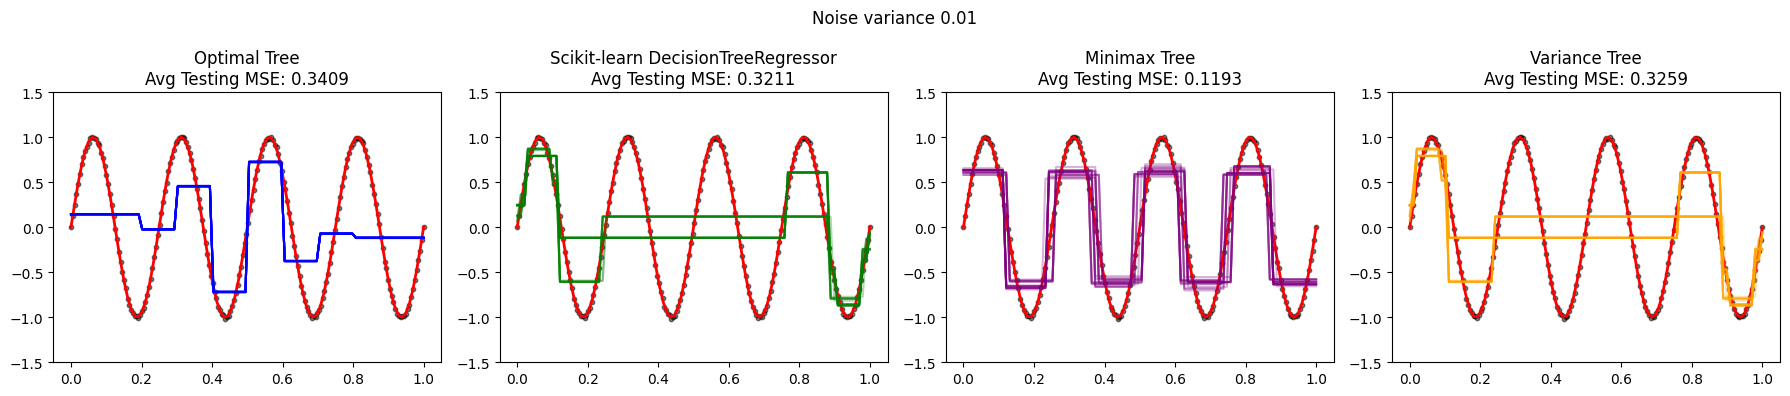

Average Optimal tree prediction MSE: 0.3409
Average Sklearn DecisionTreeRegressor MSE: 0.3211
Average MinimaxSplit tree prediction MSE: 0.1193
Average VarianceSplit tree prediction MSE: 0.3259


In [15]:
# Initialize lists to store results
custom_predictions = []
sklearn_predictions = []
variance_predictions = []
minimax_predictions = []
custom_mses = []
sklearn_mses = []
variance_mses = []
minimax_mses = []

nvars = 0.01
# Main loop
n_iterations = 20#number of repeats
for iii in range(n_iterations):
    # Generate data
    n_samples = 200 
    X = np.linspace(0, 1, n_samples).reshape(-1, 1)
    np.random.seed(iii)
    y = f_truth(X, nvars)
    X_grid = np.linspace(0, 1, 100).reshape(-1, 1)
    y_grid_true = f_truth(X_grid, nvars)

    # Optimize custom tree
    initial_splits = [0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.8]
    bounds = [(0, 1)] * 7
    constraints = [
        {'type': 'ineq', 'fun': lambda splits: splits[0] - splits[1]},
        # ... (other constraints)
    ]
    result = minimize(objective_function, initial_splits, method='SLSQP', bounds=bounds, constraints=constraints)
    s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt = result.x

    # Adjust split points
    def find_closest_point(X, split_point):
        return X[np.argmin(np.abs(X - split_point))]
    
    s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt = [find_closest_point(X, s) for s in [s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt]]

    # Predict using custom tree
    y_pred_custom = custom_tree_predict(X_grid, s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt)

    # Train and predict using sklearn's DecisionTreeRegressor
    sklearn_tree = SklearnDecisionTreeRegressor(max_depth=3)
    sklearn_tree.fit(X, y)
    variance_tree = DecisionTreeRegressor(min_samples_split=2, max_depth=3, error_method='variance')
    variance_tree.root = variance_tree.fit(X, y)

    y_pred_sklearn = sklearn_tree.predict(X_grid)
    y_pred_variance = variance_tree.predict(X_grid)

    # Train and predict using your custom DecisionTreeRegressor with minimax
    minimax_tree = DecisionTreeRegressor(min_samples_split=2, max_depth=3, error_method='cyclic_minimax')
    minimax_tree.root = minimax_tree.fit(X, y)
    y_pred_minimax = minimax_tree.predict(X_grid)

    # Calculate MSE for all methods
    mse_custom_grid = np.mean((y_grid_true - y_pred_custom) ** 2)
    mse_sklearn_grid = np.mean((y_grid_true - y_pred_sklearn) ** 2)
    mse_variance_grid = np.mean((y_grid_true - y_pred_variance) ** 2)
    mse_minimax_grid = np.mean((y_grid_true - y_pred_minimax) ** 2)

    # Store results
    custom_predictions.append(y_pred_custom)
    sklearn_predictions.append(y_pred_sklearn)
    variance_predictions.append(y_pred_variance)
    minimax_predictions.append(y_pred_minimax)
    custom_mses.append(mse_custom_grid)
    sklearn_mses.append(mse_sklearn_grid)
    variance_mses.append(mse_variance_grid)
    minimax_mses.append(mse_minimax_grid)

# Calculate average MSEs
avg_mse_custom = np.mean(custom_mses)
avg_mse_sklearn = np.mean(sklearn_mses)
avg_mse_variance = np.mean(variance_mses)
avg_mse_minimax = np.mean(minimax_mses)

# Visualize results
plt.figure(figsize=(18, 4))

# Custom Tree
plt.subplot(1, 4, 1)
plt.plot(X_grid, f_truth(X_grid,0), label='True Function', color='red', linewidth=2)
for pred in custom_predictions:
    plt.plot(X_grid, pred, alpha=0.3, color='blue')
plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
plt.title(f'Optimal Tree\nAvg Testing MSE: {avg_mse_custom:.4f}')
plt.ylim(-1.5,1.5)
#plt.legend(loc='lower left')

# Sklearn Tree
plt.subplot(1, 4, 2)
plt.plot(X_grid, f_truth(X_grid,0), label='True Function', color='red', linewidth=2)
for pred in sklearn_predictions:
    plt.plot(X_grid, pred, alpha=0.3, color='green')
plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
plt.title(f'Scikit-learn DecisionTreeRegressor\nAvg Testing MSE: {avg_mse_sklearn:.4f}')
plt.ylim(-1.5,1.5)
#plt.legend(loc='lower left')

# Minimax Tree
plt.subplot(1, 4, 3)
plt.plot(X_grid, f_truth(X_grid,0), label='True Function', color='red', linewidth=2)
for pred in minimax_predictions:
    plt.plot(X_grid, pred, alpha=0.3, color='purple')
plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
plt.title(f'Minimax Tree\nAvg Testing MSE: {avg_mse_minimax:.4f}')
plt.ylim(-1.5,1.5)
#plt.legend(loc='lower left')

# Minimax Tree
plt.subplot(1, 4, 4)
plt.plot(X_grid, f_truth(X_grid,0), label='True Function', color='red', linewidth=2)
for pred in variance_predictions:
    plt.plot(X_grid, pred, alpha=0.3, color='orange')
plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
plt.title(f'Variance Tree\nAvg Testing MSE: {avg_mse_variance:.4f}')
plt.ylim(-1.5,1.5)
#plt.legend(loc='lower left')
plt.suptitle(f'Noise variance {nvars}')
plt.tight_layout()
plt.show()

print(f"Average Optimal tree prediction MSE: {avg_mse_custom:.4f}")
print(f"Average Sklearn DecisionTreeRegressor MSE: {avg_mse_sklearn:.4f}")
print(f"Average MinimaxSplit tree prediction MSE: {avg_mse_minimax:.4f}")
print(f"Average VarianceSplit tree prediction MSE: {avg_mse_variance:.4f}")

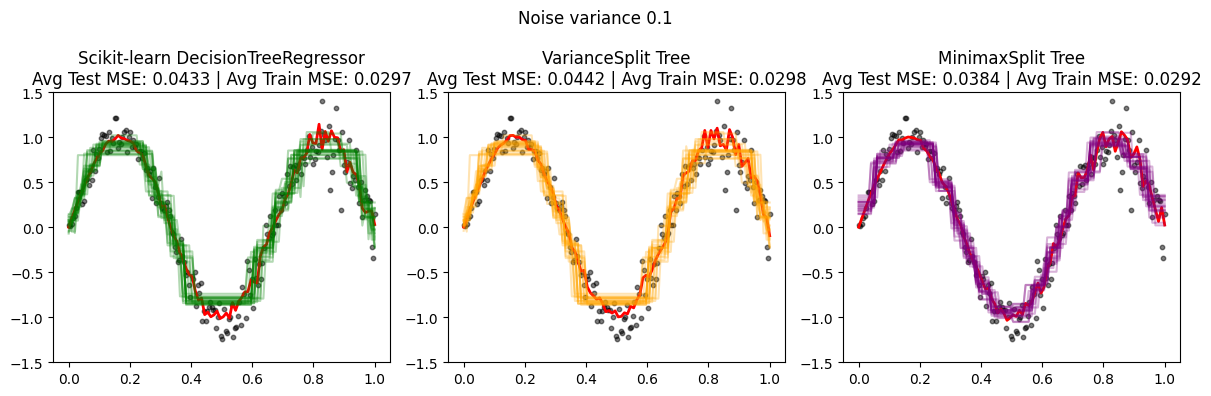

Average Optimal tree TEST MSE: 0.0895
Average Sklearn DecisionTreeRegressor TEST MSE: 0.0433
Average MinimaxSplit tree TEST MSE: 0.0384
Average VarianceSplit tree TEST MSE: 0.0442
Average Optimal tree TRAIN MSE: 0.0860
Average Sklearn DecisionTreeRegressor TRAIN MSE: 0.0297
Average MinimaxSplit tree TRAIN MSE: 0.0292
Average VarianceSplit tree TRAIN MSE: 0.0298


In [ ]:
# Initialize lists to store results
custom_predictions = []
sklearn_predictions = []
variance_predictions = []
minimax_predictions = []
custom_mses = []
sklearn_mses = []
variance_mses = []
minimax_mses = []

# NEW: training MSE collectors
custom_train_mses = []
sklearn_train_mses = []
variance_train_mses = []
minimax_train_mses = []

def f_truth(X, noise_var=0.0**2, heter=True):
    n_samples = X.shape[0]
    #X = X*5.
    #res = np.sin(X) + np.sin((10.0 / 3.0) * X)
    #res = res*0.5
    #return res.ravel() + (noise_var+X.ravel()/15) * np.random.randn(n_samples)
    #return ( np.sin(10 * np.pi * X)/(2*np.pi*(X+0.1)) + (X-1)**4 ).ravel() + noise_var * np.random.randn(n_samples) #Gramacy function
    if heter:
        return np.sin(3 * np.pi * X).ravel() +  (noise_var+X.ravel()/10) * np.random.randn(n_samples)
    else:
        return np.sin(3 * np.pi * X).ravel() +  (noise_var+X.ravel()/10) * np.random.randn(n_samples)
MY_DEPTH = 4
nvars = 0.1
# Main loop
n_iterations = 20  # number of repeats
for iii in range(n_iterations):
    # Generate data
    n_samples = 200
    X = np.linspace(0, 1, n_samples).reshape(-1, 1)
    np.random.seed(iii)
    y = f_truth(X, nvars)
    X_grid = np.linspace(0, 1, 100).reshape(-1, 1)
    y_grid_true = f_truth(X_grid, nvars)

    # Optimize custom tree
    initial_splits = [0.5, 0.3, 0.7, 0.2, 0.4, 0.6, 0.8]
    bounds = [(0, 1)] * 7
    constraints = [
        {'type': 'ineq', 'fun': lambda splits: splits[0] - splits[1]},
        # ... (other constraints)
    ]
    result = minimize(objective_function, initial_splits, method='SLSQP', bounds=bounds, constraints=constraints)
    s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt = result.x

    # Adjust split points
    def find_closest_point(X, split_point):
        return X[np.argmin(np.abs(X - split_point))]

    s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt = [find_closest_point(X, s) for s in [s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt]]

    # Predict using custom tree
    y_pred_custom = custom_tree_predict(X_grid, s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt)
    # NEW: training preds & MSE
    y_pred_custom_train = custom_tree_predict(X, s1_opt, s2_opt, s3_opt, s4_opt, s5_opt, s6_opt, s7_opt)
    mse_custom_train = np.mean((y - y_pred_custom_train) ** 2)

    # Train and predict using sklearn's DecisionTreeRegressor
    sklearn_tree = SklearnDecisionTreeRegressor(max_depth=MY_DEPTH)
    sklearn_tree.fit(X, y)
    variance_tree = DecisionTreeRegressor(min_samples_split=2, max_depth=MY_DEPTH, error_method='variance')
    variance_tree.root = variance_tree.fit(X, y)

    y_pred_sklearn = sklearn_tree.predict(X_grid)
    y_pred_variance = variance_tree.predict(X_grid)

    # NEW: training preds & MSE for sklearn/variance
    y_pred_sklearn_train = sklearn_tree.predict(X)
    y_pred_variance_train = variance_tree.predict(X)
    mse_sklearn_train = np.mean((y - y_pred_sklearn_train) ** 2)
    mse_variance_train = np.mean((y - np.array(y_pred_variance_train)) ** 2)

    # Train and predict using your custom DecisionTreeRegressor with minimax
    minimax_tree = DecisionTreeRegressor(min_samples_split=2, max_depth=MY_DEPTH, error_method='cyclic_minimax')
    minimax_tree.root = minimax_tree.fit(X, y)
    y_pred_minimax = minimax_tree.predict(X_grid)

    # NEW: training preds & MSE for minimax
    y_pred_minimax_train = minimax_tree.predict(X)
    mse_minimax_train = np.mean((y - np.array(y_pred_minimax_train)) ** 2)

    # Calculate MSE for all methods (grid/testing)
    mse_custom_grid = np.mean((y_grid_true - y_pred_custom) ** 2)
    mse_sklearn_grid = np.mean((y_grid_true - y_pred_sklearn) ** 2)
    mse_variance_grid = np.mean((y_grid_true - np.array(y_pred_variance)) ** 2)
    mse_minimax_grid = np.mean((y_grid_true - np.array(y_pred_minimax)) ** 2)

    # Store results
    custom_predictions.append(y_pred_custom)
    sklearn_predictions.append(y_pred_sklearn)
    variance_predictions.append(y_pred_variance)
    minimax_predictions.append(y_pred_minimax)
    custom_mses.append(mse_custom_grid)
    sklearn_mses.append(mse_sklearn_grid)
    variance_mses.append(mse_variance_grid)
    minimax_mses.append(mse_minimax_grid)

    # NEW: store training MSEs
    custom_train_mses.append(mse_custom_train)
    sklearn_train_mses.append(mse_sklearn_train)
    variance_train_mses.append(mse_variance_train)
    minimax_train_mses.append(mse_minimax_train)

# Calculate average TEST MSEs
avg_mse_custom = np.mean(custom_mses)
avg_mse_sklearn = np.mean(sklearn_mses)
avg_mse_variance = np.mean(variance_mses)
avg_mse_minimax = np.mean(minimax_mses)

# NEW: Calculate average TRAIN MSEs
avg_train_mse_custom = np.mean(custom_train_mses)
avg_train_mse_sklearn = np.mean(sklearn_train_mses)
avg_train_mse_variance = np.mean(variance_train_mses)
avg_train_mse_minimax = np.mean(minimax_train_mses)

# Visualize results
plt.figure(figsize=(12, 4))

# Custom Tree
#plt.subplot(1, 4, 1)
#plt.plot(X_grid, f_truth(X_grid,0), label='True Function', color='red', linewidth=2)
#for pred in custom_predictions:
#    plt.plot(X_grid, pred, alpha=0.3, color='blue')
#plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
#plt.title(f'Optimal Tree\nAvg Test MSE: {avg_mse_custom:.4f} | Avg Train MSE: {avg_train_mse_custom:.4f}')  # NEW
#plt.ylim(-1.5,1.5)

# Sklearn Tree
plt.subplot(1, 3, 1)
plt.plot(X_grid, f_truth(X_grid,0), label='True Function', color='red', linewidth=2)
for pred in sklearn_predictions:
    plt.plot(X_grid, pred, alpha=0.3, color='green')
plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
plt.title(f'Scikit-learn DecisionTreeRegressor\nAvg Test MSE: {avg_mse_sklearn:.4f} | Avg Train MSE: {avg_train_mse_sklearn:.4f}')  # NEW
plt.ylim(-1.5,1.5)

# Minimax Tree
plt.subplot(1, 3, 3)
plt.plot(X_grid, f_truth(X_grid,0), label='True Function', color='red', linewidth=2)
for pred in minimax_predictions:
    plt.plot(X_grid, pred, alpha=0.3, color='purple')
plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
plt.title(f'MinimaxSplit Tree\nAvg Test MSE: {avg_mse_minimax:.4f} | Avg Train MSE: {avg_train_mse_minimax:.4f}')  # NEW
plt.ylim(-1.5,1.5)

# Variance Tree
plt.subplot(1, 3, 2)
plt.plot(X_grid, f_truth(X_grid,0), label='True Function', color='red', linewidth=2)
for pred in variance_predictions:
    plt.plot(X_grid, pred, alpha=0.3, color='orange')
plt.scatter(X, y, c='black', alpha=0.5, s=10, label='Training Data')
plt.title(f'VarianceSplit Tree\nAvg Test MSE: {avg_mse_variance:.4f} | Avg Train MSE: {avg_train_mse_variance:.4f}')  # NEW
plt.ylim(-1.5,1.5)
plt.suptitle(f'Noise variance {nvars}')
plt.tight_layout()
plt.show()

print(f"Average Optimal tree TEST MSE: {avg_mse_custom:.4f}")
print(f"Average Sklearn DecisionTreeRegressor TEST MSE: {avg_mse_sklearn:.4f}")
print(f"Average MinimaxSplit tree TEST MSE: {avg_mse_minimax:.4f}")
print(f"Average VarianceSplit tree TEST MSE: {avg_mse_variance:.4f}")

# NEW: print training errors
print(f"Average Optimal tree TRAIN MSE: {avg_train_mse_custom:.4f}")
print(f"Average Sklearn DecisionTreeRegressor TRAIN MSE: {avg_train_mse_sklearn:.4f}")
print(f"Average MinimaxSplit tree TRAIN MSE: {avg_train_mse_minimax:.4f}")
print(f"Average VarianceSplit tree TRAIN MSE: {avg_train_mse_variance:.4f}")
